# **Light intensity dependence**

_by Felix Eickemeyer_

Calculation of PLQY for each sample.

In [22]:
import sys
import warnings
import os
import math

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, least_squares
import thot
from thot import ThotProject

from FTE_analysis_libraries import General as gen
from FTE_analysis_libraries import PLQY as lqy
from FTE_analysis_libraries import Spectrum as spc
from FTE_analysis_libraries import IV

if True:
    import importlib
    from importlib import reload
    reload(gen)

In [2]:
def load_spectrum(LP):
    return spc.PEL_spectrum.load(os.path.dirname(LP.file), FN = os.path.basename(LP.file), take_quants_and_units_from_file = True)

def spec_adjust(fs, sp, x_lim, title='Spectrum correction', show_adjust_factor = False, save_plots = False, show_plots = True, divisor = 1e3):
    # adj_factor: manual adjustment factor. It is advisable to run this routine first with show_adjust_factor = True and then take this as a basis for the adj_factor
    # automatically calculate the factor

    def guess_factor(left, right):
        """
        Returns the inbeam or outofbeam-free space adjustment factor.
        """

        fs_ = fs.copy()
        sp_ = sp.copy()

        delta = fs_.x[1] - fs_.x[0] 
        fs_.equidist(left = left, right = right, delta = delta)
        sp_.equidist(left = left, right = right, delta = delta)

        def f(fac): 
            diff = sp_.y - fac * fs_.y
            return math.sqrt(1/len(diff) * np.dot(diff, diff))

        result = least_squares(fun = f, x0 = [1])

        return result.x[0]

    left = x_lim[0]
    right = x_lim[1]

    factor = guess_factor(left = left, right = right)

    if show_adjust_factor:
        print(f'The adjust factor is {factor:.2e}')

    sp_new = sp.copy()
    sp_new.y = fs.y * factor  

    fssp = spc.PEL_spectra([sp, sp_new])
    fssp.label(['original', 'adjusted'])

    if show_plots:
        fssp_lin_graph = fssp.plot(yscale='linear', left=param.PL_left, right=param.PL_right, title=title, figsize=(7,5), return_fig = True, show_plot = show_plots)

    return sp_new

In [3]:
# Initializes Thot project
db = ThotProject( dev_root = r'PLQY_results' )
root = db.find_container( dict(_id = db.root) )

In [4]:
#Perovskite

if 'sample_type' in root.metadata:
    which_sample = root.metadata[ 'sample_type' ]

else:
    # default sample type
    # which_sample = 'Haizhou-FAPbI3'
    which_sample = 'FAPbI3'

    #DSC
    #which_sample = 'Yameng DSC'
    #which_sample = 'dye on TiO2'
    #which_sample = 'dye on Al2O3'
    #which_sample = 'Coumarin 153'
    #which_sample = 'MS5'
    #which_sample = 'XY1b'

param = lqy.exp_param(which_sample=which_sample,
                      excitation_laser=None,
                      PL_left=None,
                      PL_right=None,
                      PL_peak=None,
                      corr_offs_left=40,
                      corr_offs_right=50,
                      PL_peak_auto=False,
                      eval_Pb=False)

param2 = lqy.exp_param(which_sample=None,
                      excitation_laser=422,
                      PL_left=470,
                      PL_right=600,
                      PL_peak=None,
                      corr_offs_left=20,
                      corr_offs_right=30,
                      PL_peak_auto=True,
                      eval_Pb=False)


In [5]:
samples = db.find_assets({'type' : 'calibrated PL spectrum'})
names = list({sample.metadata['name'] for sample in samples})
print(names)
conditions = list('OD'+str(int(sample.metadata['OD_filter']))+', laser power '+str(sample.metadata['laser_mW'])+' mW' for sample in samples)

if False and db.dev_mode():
    for sample, condition in zip(samples, conditions):
        print(sample.metadata['name']+', '+condition)

['FAPI_ref', 'FAPI_OAI_tBP', 'FAPI_OAI', 'FAPI_tBP']


In [14]:
# Light intensities

LI = pd.DataFrame({'OD_filter': [1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0], 'laser_mW': [3.5, 1.6, 0.8, 3.5, 1.6, 0.8, 3.5, 1.6, 0.8], 'laser_uW_at_sample': [318.0, 144.0, 69.1, 47.8, 21.6, 10.6, 3.89, 1.78, 0.87]})
laser_uW_at_1sun = LI[(LI['OD_filter'] == 1.0) & (LI['laser_mW'] == 3.5)]['laser_uW_at_sample'].values[0]
LI['nsun'] = LI['laser_uW_at_sample'] / laser_uW_at_1sun
bg = 1.53
LI['SQlimit'] = [IV.IV_data.SQ_limit_Voc(bg, illumspec_eV = None, light_int = 100*nsun, from_file = False) for nsun in LI['nsun']]
print(LI)

# PLQY
PLQYat1sun = pd.DataFrame({'names': ['FAPI_ref', 'FAPI_tBP', 'FAPI_OAI_tBP', 'FAPI_OAI'], 'PLQY': [0.1, 0.1 , 0.257, 0.185]})
print(PLQYat1sun)

   OD_filter  laser_mW  laser_uW_at_sample      nsun   SQlimit
0        1.0       3.5              318.00  1.000000  1.260560
1        1.0       1.6              144.00  0.452830  1.240205
2        1.0       0.8               69.10  0.217296  1.221340
3        2.0       3.5               47.80  0.150314  1.211872
4        2.0       1.6               21.60  0.067925  1.191463
5        2.0       0.8               10.60  0.033333  1.173174
6        3.0       3.5                3.89  0.012233  1.147419
7        3.0       1.6                1.78  0.005597  1.127333
8        3.0       0.8                0.87  0.002736  1.108940
          names   PLQY
0      FAPI_ref  0.100
1      FAPI_tBP  0.100
2  FAPI_OAI_tBP  0.257
3      FAPI_OAI  0.185



0____________________________
FAPI_ref


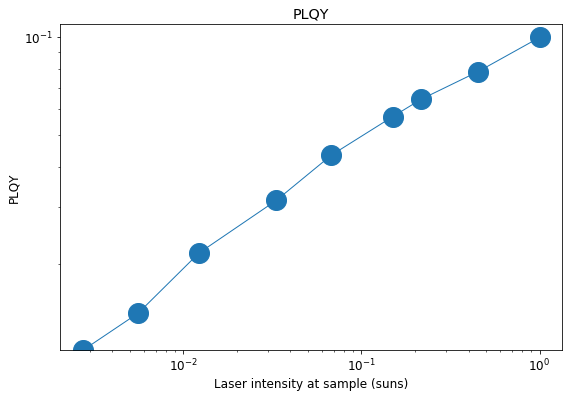

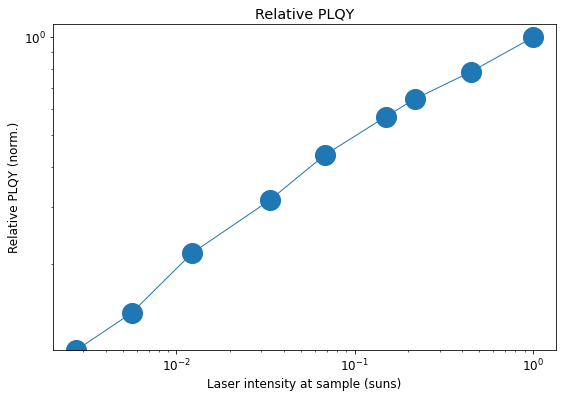

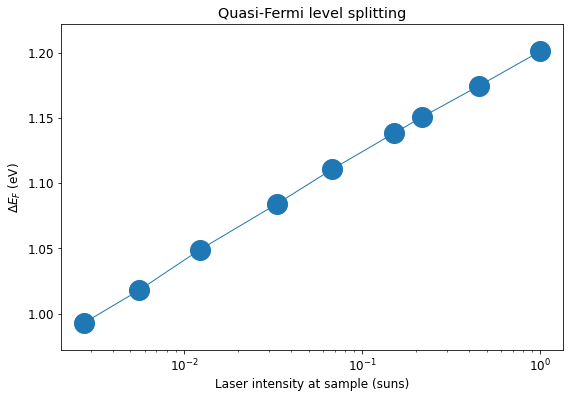


1____________________________
FAPI_OAI_tBP


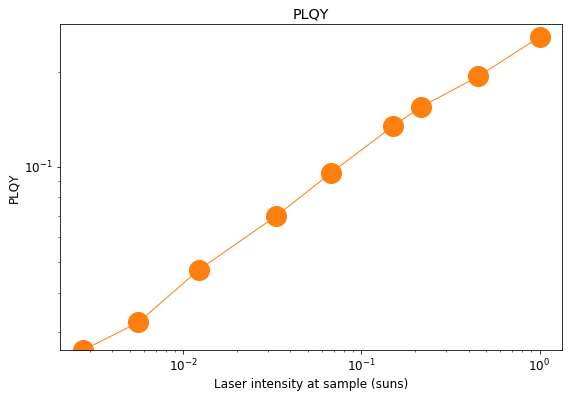

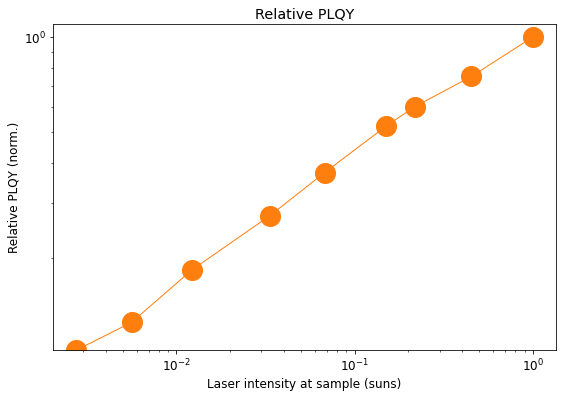

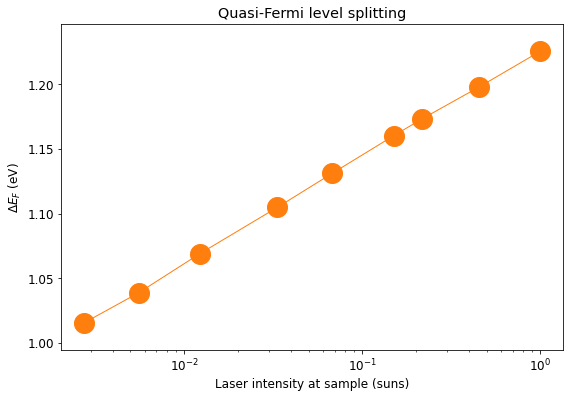


2____________________________
FAPI_OAI


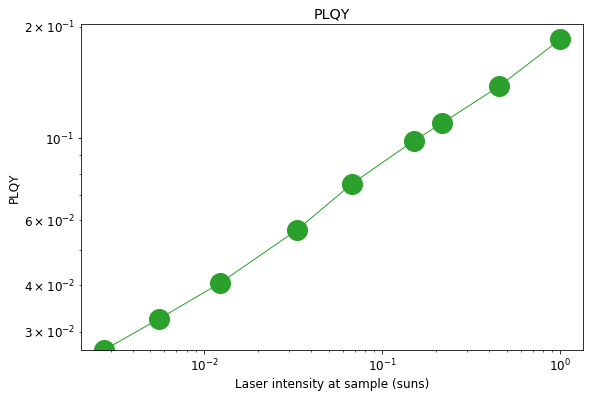

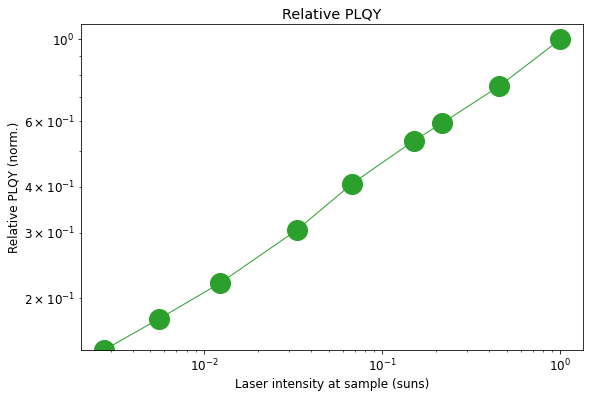

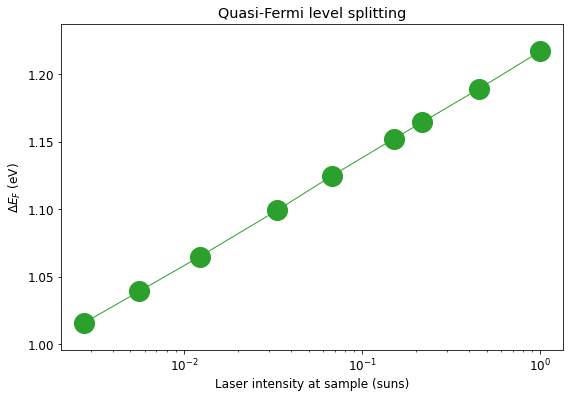


3____________________________
FAPI_tBP


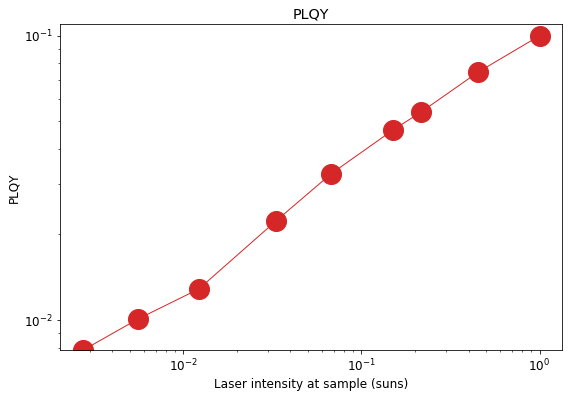

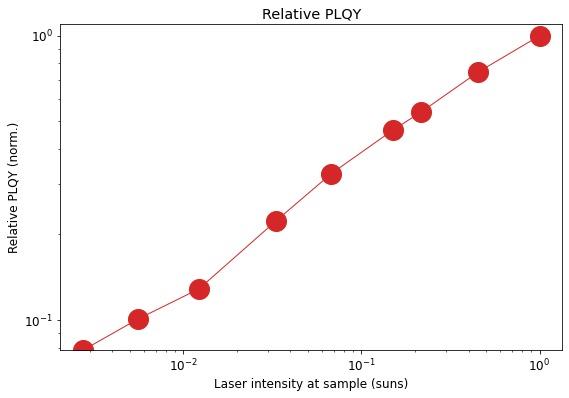

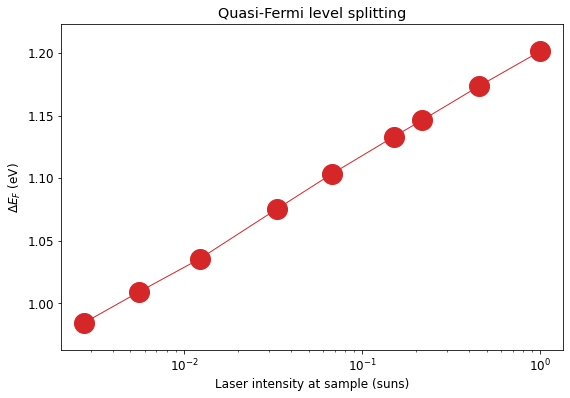

In [20]:
# You can change maxNumberOutputs in settings: click on Menu bar → Settings → Advanced Settings Editor → Notebook → set maxNumberOutputs in the User Preferences tab, like:
# {
#     "maxNumberOutputs": 0
# }

show_details = ( True and db.dev_mode() )
save_plots = ( False or not db.dev_mode() )

LI_PLQYs = []
LI_QFLSs = []
LI_relPLQYs = []

for idx in range(len(names)):

    sample_name = names[idx]


    print(f'\n{idx:}____________________________')
    print(sample_name)

    group = thot.filter({'metadata.name' : sample_name}, samples)

    # Find the samples with the highest PL signal
    fs_sample = thot.filter({'metadata.OD_filter': 1.0, 'metadata.laser_mW': 3.5}, group)
    if len(fs_sample) > 1:
        print('Attention: There is more than one data for OD1 and 3.5mW')
    fs = load_spectrum(fs_sample[0]).cut_data_outside(left=param.PL_left, right=param.PL_right)
    fs_PLQYat1sun = PLQYat1sun[PLQYat1sun['names'] == sample_name]['PLQY'].values[0]
    fs_PF = fs.calc_integrated_photonflux(start=param.PL_left, stop=param.PL_right)

    sa = []
    PLQYs = []
    relPLQYs = []
    QFLSs = []
    LIs = []

    for sample in group:
        #print(sample.metadata['name']+', OD'+str(sample.metadata['OD_filter'])+', laser power '+str(sample.metadata['laser_mW'])+' mW')
        OD_filter = sample.metadata['OD_filter']
        laser_mW = sample.metadata['laser_mW']
        laser_uW_at_sample = LI[(LI['OD_filter'] == OD_filter) & (LI['laser_mW'] == laser_mW)]['laser_uW_at_sample'].values[0]
        SQlimit = LI[(LI['OD_filter'] == OD_filter) & (LI['laser_mW'] == laser_mW)]['SQlimit'].values[0]
        #print(laser_uW_at_sample)
        nsun = LI[(LI['OD_filter'] == OD_filter) & (LI['laser_mW'] == laser_mW)]['nsun'].values[0]
        if not(nsun == laser_uW_at_sample/laser_uW_at_1sun):
            print('Attention: There is a problem with the caluclation of nsun!')

        sp = load_spectrum(sample).cut_data_outside(left=param.PL_left, right=param.PL_right)
        title=f'Filter: OD{OD_filter}, laser power: {laser_mW} mW'
        #sp.plot(title=title)
        title=f'Spectrum correction for filter: OD{OD_filter}, laser power: {laser_mW} mW'
        sp_corrected = spec_adjust(fs, sp, x_lim=[790, 830], title=title, show_plots=False)

        #PF = sp.calc_integrated_photonflux(start = 750, stop = 870)
        PF = sp_corrected.calc_integrated_photonflux(start=param.PL_left, stop=param.PL_right)
        sp_PLQY = PF/laser_uW_at_sample / (fs_PF/laser_uW_at_1sun) * fs_PLQYat1sun
        sp_QFLS = SQlimit + gen.V_loss(sp_PLQY)
        sp_relPLQY = PF/laser_uW_at_sample / (fs_PF/laser_uW_at_1sun)

        LIs.append(nsun)
        PLQYs.append(sp_PLQY)
        QFLSs.append(sp_QFLS)
        relPLQYs.append(sp_relPLQY)
        sp.normalize(x_lim=[800, 820])
        sa.append(sp)

    def LI_y_dat(y_arr, qy, uy, color = gen.colors[idx]):
        LI_y = spc.xy_data(np.array(LIs), y_arr, quants=dict(x='Laser intensity at sample', y=qy), units=dict(x='suns', y=uy), check_data = False)
        LI_y.plotstyle = dict(linestyle = '-', marker = 'o', color = color, linewidth = 1, markersize = 20)
        LI_y.monotoneous_ascending()
        return LI_y

    LI_PLQY = LI_y_dat(np.array(PLQYs), qy='PLQY', uy = '')
    LI_PLQY.plot(xscale='log', yscale='log', title='PLQY')

    LI_relPLQY = LI_y_dat(np.array(relPLQYs), qy='Relative PLQY', uy = 'norm.')
    LI_relPLQY.plot(xscale='log', yscale='log', title='Relative PLQY')

    LI_QFLS = LI_y_dat(np.array(QFLSs), qy='$\Delta E_F$', uy = 'eV')
    LI_QFLS.plot(xscale='log', yscale='linear', title='Quasi-Fermi level splitting')

    P = spc.PEL_spectra(sa)
    #P.plot()

    LI_PLQYs.append(LI_PLQY)
    LI_QFLSs.append(LI_QFLS)
    LI_relPLQYs.append(LI_relPLQYs)


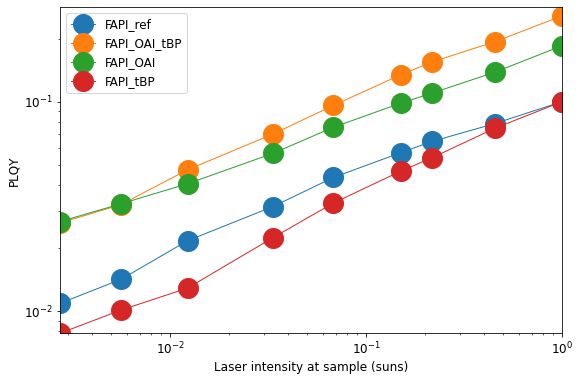

In [21]:
all_LI_PLQYs = spc.mxy_data(LI_PLQYs)
all_LI_PLQYs.label(names)
all_LI_PLQYs.plot(xscale='log', yscale='log', plotstyle = 'individual')

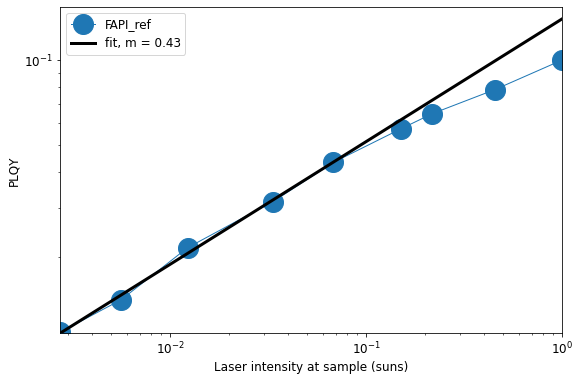

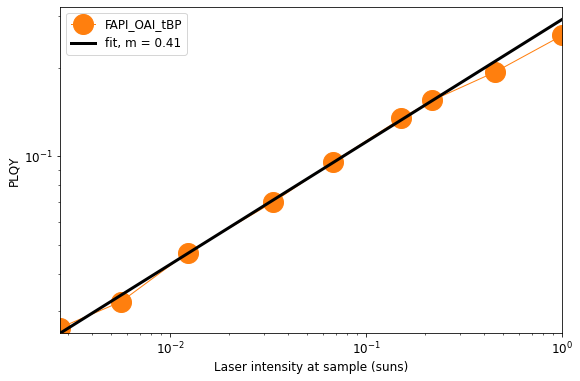

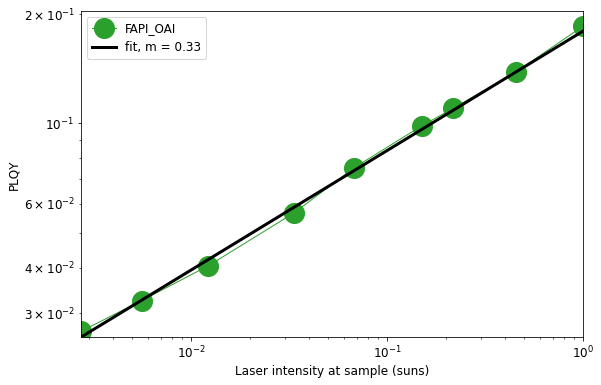

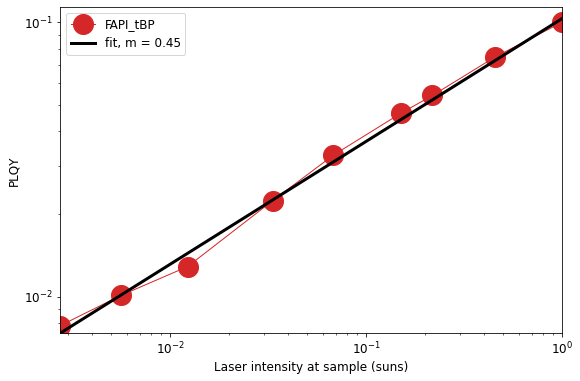

In [32]:
# Choose data
for idx in range(len(names)):
    dat = all_LI_PLQYs.sa[idx]

    m, b = gen.linfit(np.log10(dat.x), np.log10(dat.y))
    fit_y = 10**(b + m*np.log10(dat.x))
    fit = spc.xy_data(dat.x, fit_y, name=f'fit, m = {m:.2f}')

    both = spc.mxy_data([dat, fit])
    both.label([names[idx], fit.name])
    both.plot(xscale='log', yscale='log', plotstyle = 'individual')
